In [7]:
# !pip install kagglehub
# !pip install textblob
# !pip install textstat

In [11]:
import os
import pandas as pd
import numpy as np
import kagglehub
from textblob import TextBlob
import textstat
import seaborn as sns
import matplotlib.pyplot as plt

dataset_path = kagglehub.dataset_download('saurabhshahane/fake-news-classification')

print("Path to dataset files:", dataset_path)

raw_dataset = os.path.join(dataset_path, 'WELFake_Dataset.csv')
df = pd.read_csv(raw_dataset)

print(df.head())

Path to dataset files: /Users/jacksonglass/.cache/kagglehub/datasets/saurabhshahane/fake-news-classification/versions/77
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  


Text(0.5, 1.0, 'Fake vs Real Articles Count')

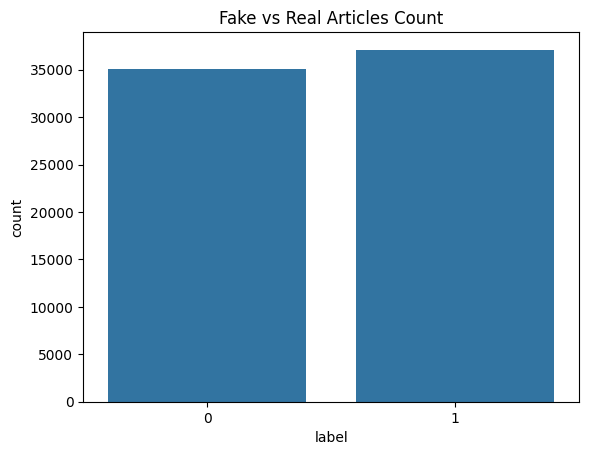

In [12]:
sns.countplot(x="label", data=df)
plt.title("Fake vs Real Articles Count")

Text(0.5, 1.0, 'Word Count — Fake vs Real')

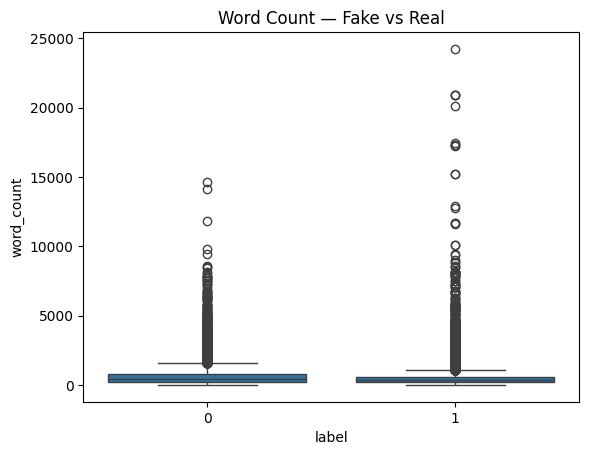

In [14]:
df["word_count"] = df["text"].apply(lambda t: len(str(t).split()))
df["char_count"] = df["text"].apply(lambda t: len(str(t)))

sns.boxplot(x="label", y="word_count", data=df)
plt.title("Word Count — Fake vs Real")

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

#top word counts from fake and real news articles
df_clean = df.dropna(subset=["text"])

fake_text = df_clean[df_clean["label"] == 1]["text"]
real_text = df_clean[df_clean["label"] == 0]["text"]

cv = CountVectorizer(stop_words="english", max_features=20)

fake_counts = cv.fit_transform(fake_text)
fake_words = pd.DataFrame({
    "word": cv.get_feature_names_out(),
    "count": fake_counts.toarray().sum(axis=0)
}).sort_values(by="count", ascending=False)

real_counts = cv.fit_transform(real_text)
real_words = pd.DataFrame({
    "word": cv.get_feature_names_out(),
    "count": real_counts.toarray().sum(axis=0)
}).sort_values(by="count", ascending=False)

fake_words, real_words


(          word   count
 17       trump  106364
 14        said   49712
 12      people   48653
 1      clinton   45411
 13   president   38982
 6         just   34612
 7         like   31766
 5      hillary   31592
 11       obama   28615
 9          new   28334
 16        time   26155
 15       state   25340
 2       donald   24955
 10        news   21866
 0     american   20847
 8        media   20393
 3     election   20309
 4   government   20190
 19       world   19811
 18       white   19445,
           word   count
 12        said  184607
 17       trump  107201
 5           mr   66086
 9    president   51300
 6          new   42528
 8       people   41792
 13       state   38871
 14      states   31668
 2   government   30110
 11     reuters   29342
 3        house   28578
 1      clinton   28569
 19        year   28154
 18      united   27740
 10  republican   26548
 4         like   24796
 16        told   23991
 0     campaign   23383
 15        time   23335
 7        obama

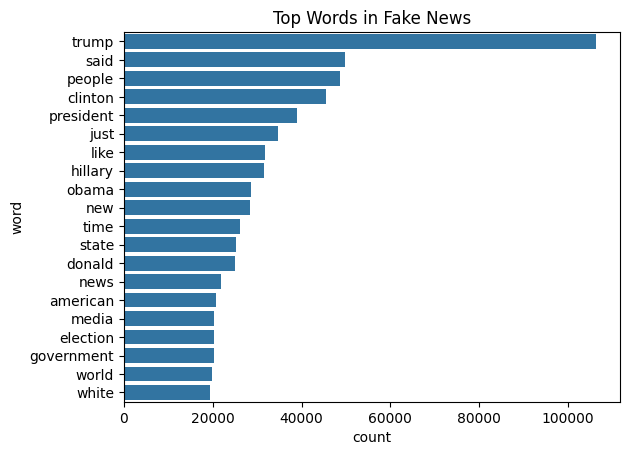

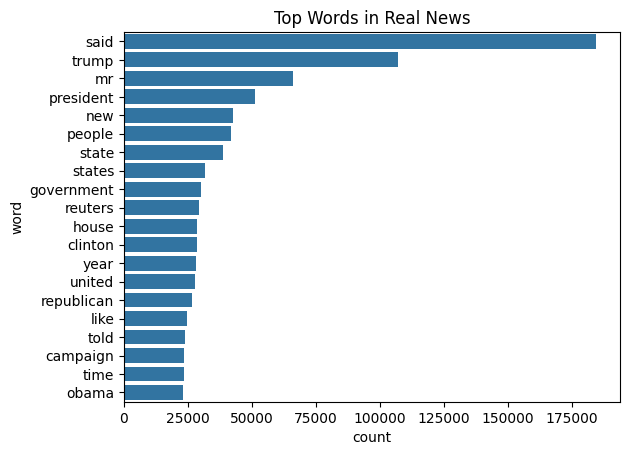

In [16]:
#plots of word counts
sns.barplot(
    data=fake_words,
    x="count",
    y="word"
)
plt.title("Top Words in Fake News")
plt.show()

sns.barplot(
    data=real_words,
    x="count",
    y="word"
)
plt.title("Top Words in Real News")
plt.show()

In [17]:
sample_size = 10000  # total

df_sample = (
    df_clean
    .groupby("label", group_keys=False)
    .apply(lambda x: x.sample(sample_size // 2, random_state=42))
)


/var/folders/8g/pz1h2bxn525cwwzfygrtsxbh0000gn/T/ipykernel_45934/3372995961.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(sample_size // 2, random_state=42))


Text(0.5, 1.0, 'VADER Sentiment Distribution: Fake vs Real')

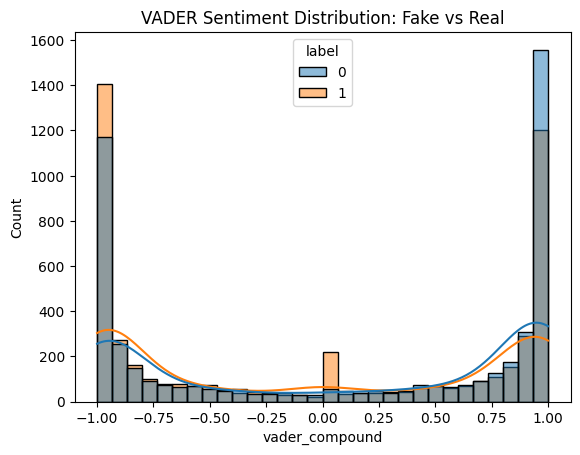

In [11]:
#sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df_sample["vader_compound"] = df_sample["text"].apply(lambda t: analyzer.polarity_scores(t)["compound"])
sns.histplot(
    data=df_sample,
    x="vader_compound",
    hue="label",
    bins=30,
    kde=True
)
plt.title("VADER Sentiment Distribution: Fake vs Real")

<Axes: xlabel='label', ylabel='flesch'>

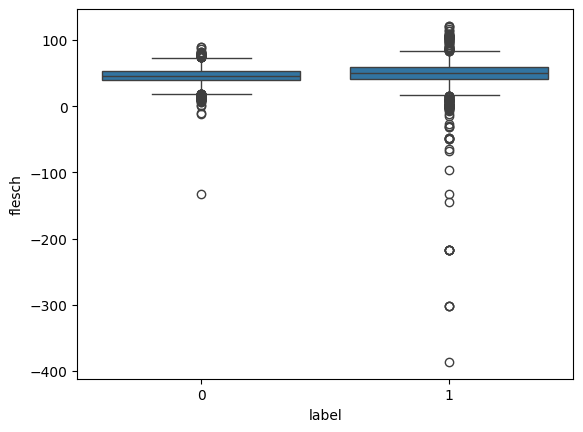

In [12]:
#readibility metrics
df_sample["flesch"] = df_sample["text"].apply(lambda t: textstat.flesch_reading_ease(str(t)))

sns.boxplot(x="label", y="flesch", data=df_sample)

C:\Users\qtg4ys\AppData\Local\Temp\ipykernel_7520\2766944691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["word_count"] = df_clean["text"].apply(lambda t: len(str(t).split()))


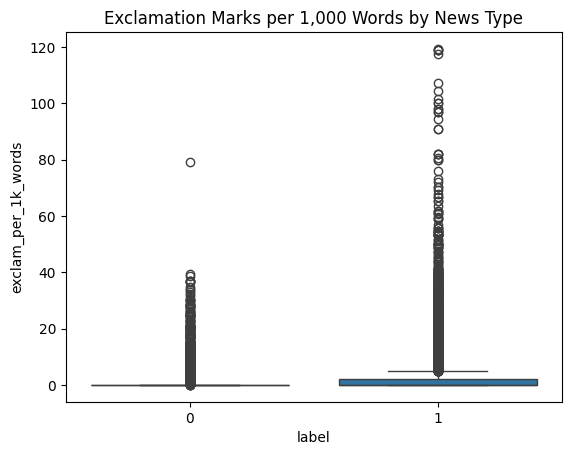

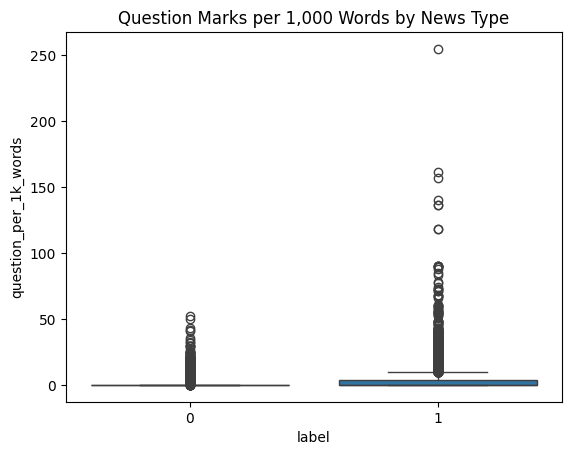

In [13]:
#punctuation counts
df_clean["word_count"] = df_clean["text"].apply(lambda t: len(str(t).split()))
df_clean = df_clean[df_clean["word_count"] >= 50]
df_clean["exclamations"] = df_clean["text"].apply(lambda t: str(t).count("!"))
df_clean["questions"] = df_clean["text"].apply(lambda t: str(t).count("?"))

df_clean["exclam_per_1k_words"] = (
    df_clean["exclamations"] / df_clean["word_count"]
) * 1000

df_clean["question_per_1k_words"] = (
    df_clean["questions"] / df_clean["word_count"]
) * 1000

sns.boxplot(
    x="label",
    y="exclam_per_1k_words",
    data=df_clean
)
plt.title("Exclamation Marks per 1,000 Words by News Type")
plt.show()

sns.boxplot(
    x="label",
    y="question_per_1k_words",
    data=df_clean
)
plt.title("Question Marks per 1,000 Words by News Type")
plt.show()


In [14]:
df_clean.sort_values(
    "question_per_1k_words",
    ascending=False
).head(10)[["text", "word_count", "question_per_1k_words", "label"]]


,text,word_count,question_per_1k_words,label
37815,White House deputy press secretary Sarah Hucka...,369,254.742547,1
64830,VOTE for Trump!!!! WE CAN DO IT GET OUT AND vo...,68,161.764706,1
69874,#TrumpTrain??????????@realDonaldTrump isn t go...,70,157.142857,1
18904,Shock!!!! Hasn't this been in the news for yea...,57,140.350877,1
31502,Can't say under God at Hilary speech!?!??!?? L...,110,136.363636,1
13860,Can't say under God at Hilary speech!?!??!?? L...,110,136.363636,1
14095,"Once you ve read this list, you re going to wa...",288,118.055556,1
61925,"Once you ve read this list, you re going to wa...",288,118.055556,1
23110,iTS DARK ALRIGHT . In a sad twist of fate thes...,89,89.887640,1
25190,iTS DARK ALRIGHT . In a sad twist of fate thes...,89,89.887640,1


In [18]:
fake_df = df_clean[(df_clean["label"] == 0)]
fake_df.sort_values(
    "question_per_1k_words",
    ascending=False
).head(5)[["text", "word_count", "question_per_1k_words", "label"]]

,text,word_count,question_per_1k_words,label
20441,WASHINGTON (Reuters) - President Donald Trump ...,96,52.083333,0
55977,"During this week’s “Saturday Night Live,” Alec...",140,50.000000,0
29007,What if the latest craze among the big-governm...,920,43.478261,0
57615,"Friday in Washington, D. C. at the Partnership...",216,41.666667,0
37878,What if Hillary Clinton is in legal hot water ...,929,40.904198,0
